---
title: 3 Layer Stacked QG Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Stacked QG
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: roxyboy.guppy@gmail.com
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [46]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import einops
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import typing as tp
import einops

from jaxsw._src.domain.base import Domain
from jaxsw._src.operators.functional import advection as F_adv
from jaxsw._src.operators.functional import geostrophic as F_geos
from jaxsw._src.operators.functional import cgrid as F_cgrid
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.operators.functional import interp as F_interp
from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz
from jaxsw._src.models import qg_louis as F_louis
from jaxsw._src.models import qg_ml as F_qgml

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from loguru import logger


def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 2))

    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i], cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    logger.debug(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In this problem, we are looking at sea surface height (SSH) in relation to the Quasi-Geostrophic (QG) equations. These equations are a simplified form for the Navier-Stokes equations with approximations like *hydrostatic approximation*, *small aspect ratio*, and a *small Rossby number*. Ideally, these equations might be a decent approximation at mesoscale (100km - 10,000km). In this application, we will see how SSH propagates with the QG equations.

## Equations


$$
\partial_t q_k + (u_kq_k)_x + (v_kq_k)_y = F_k + D_k
$$ (eq:qg_form_adv)

The term that links each of the layers together, $\mathbf{A}$, is a tri-diagonal matrix that can be written as

$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_1'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In the paper [[Thiry et al., 2023](https://doi.org/10.22541/essoar.167397445.54992823/v1),[Thiry et al., 2023](https://egusphere.copernicus.org/preprints/2023/egusphere-2023-1715/)], they use the following method

$$
\begin{aligned}
\text{Hyperviscosity}: && 
\boldsymbol{D_1} &= 
-a_4\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

$$
\begin{aligned}
\Omega_\psi &\in[N_x,N_y] && && [x_0,y_0] && && [x_1,y_1] \\ 
\Omega_u &\in[N_x,N_y+1] && && [x_0,y_0-\frac{1}{2}dy] && && [x_1,y_1+\frac{1}{2}dy]  \\ 
\Omega_v &\in[N_x+1,N_y] && && [x_0-\frac{1}{2}dx,y_0] && && [x_1+\frac{1}{2}dx,y_1]  \\ 
\Omega_q &\in[N_x-1,N_y-1] && && [x_0+\frac{1}{2}dx,y_0+\frac{1}{2}dy] && && [x_1-\frac{1}{2}dx,y_1-\frac{1}{2}dy] 
\end{aligned}
$$

## Parameters

In [48]:
F_qgml.PDEParams??

Init signature: F_qgml.PDEParams(*args, **kwargs)
Docstring:      PDEParams(*args, **kwargs)
Source:        
class PDEParams(eqx.Module):
    f0: float = 9.375e-5  # coriolis [s^-1]
    beta: float = 1.754e-11  # coriolis gradient [m^-1 s^-1]
    tau0: float = 2.0e-5  # wind stress magnitude m/s^2
    y0: float = 2_400_000.0  # [m]
    a_2: float = 0.0  # laplacian diffusion coef (m^2/s)
    a_4: float = 5.0e11  # LR # 2.0e9 # HR
    bcco: float = 0.2  # boundary condition coef. (non-dim.)
    delta_ek: float = 2.0  # eckman height [m]

    @property
    def zfbc(self):
        return self.bcco / (1.0 + 0.5 * self.bcco)
File:           ~/code_projects/jaxsw/jaxsw/_src/models/qg_ml.py
Type:           _ModuleMeta
Subclasses:     PDEParams

In [49]:
a_4 = 5.0e11  # 2.0e9 #
params = F_qgml.PDEParams()

## Domain

In [50]:
import jaxsw._src.domain.base_v2 as Domain

In [51]:
# Low Resolution
Nx, Ny = 97, 121
# High Resolution
# Nx, Ny = 769, 961

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 5_120.0e3, 5_120.0e3

x_domain = Domain.init_domain_1d(Lx, Nx)
y_domain = Domain.init_domain_1d(Ly, Ny)
x_domain, y_domain
xy_domain = x_domain * y_domain


In [52]:
def check_field_shapes(u: Array, name: str="psi"):

    shape = np.array(u).shape[-2:]
    if name == "psi":
        true_shape = (Nx, Ny)
        msg = f"Wrong Shape:"
        msg += f"\n{shape} | {name}:{true_shape}"
        assert shape == true_shape, msg
    elif name == "psi_i":
        true_shape = (Nx-2,Ny-2)
        msg = f"Wrong Shape:"
        msg += f"\n{shape} | {name}:{true_shape}"
        assert shape == true_shape, msg
    elif name == "u":
        true_shape = (Nx,Ny-1)
        msg = f"Wrong Shape:"
        msg += f"\n{shape} | {name}:{true_shape}"
        assert shape == true_shape, msg
    elif name == "u_i":
        true_shape = (Nx-2,Ny-1)
        msg = f"Wrong Shape:"
        msg += f"\n{shape} | {name}:{true_shape}"
        assert shape == true_shape, msg
    elif name == "v":
        true_shape = (Nx-1,Ny)
        msg = f"Wrong Shape:"
        msg += f"\n{shape} | {name}:{true_shape}"
        assert shape == true_shape, msg
    elif name == "v_i":
        true_shape = (Nx-1,Ny-2)
        msg = f"Wrong Shape:"
        msg += f"\n{shape} | {name}:{true_shape}"
        assert shape == true_shape, msg
    elif name == "q":
        true_shape = (Nx-1,Ny-1)
        msg = f"Wrong Shape:"
        msg += f"\n{shape} | {name}:{true_shape}"
        assert shape == true_shape, msg
    else:
        raise ValueError(f"Unreocngized field: {name}")
        

In [53]:
check_field_shapes(xy_domain.grid_axis[0], name="psi")
check_field_shapes(xy_domain.grid_axis[1], name="psi")

In [54]:
xy_domain.dx, xy_domain.Nx, xy_domain.Lx, xy_domain.cell_volume, xy_domain.ndim

((0.010416666666666666, 0.008333333333333333),
 (97, 121),
 (5120000.0, 5120000.0),
 8.680555555555555e-05,
 2)

## Masks

In [61]:
from jaxsw._src.masks import Mask

mask = jnp.ones((Nx,Ny))
mask = mask.at[0].set(0.0)
mask = mask.at[-1].set(0.0)
mask = mask.at[:,0].set(0.0)
mask = mask.at[:,-1].set(0.0)

masks = Mask.init_mask(mask, variable="psi")

### Heights


Remember equation [](#eq:qg_A)

In [64]:
from jaxsw._src.domain.qg import create_qg_multilayer_mat, LayerDomain
# LayerDomain??
create_qg_multilayer_mat??

Signature:
create_qg_multilayer_mat(
    heights: List[float],
    reduced_gravities: List[float],
) -> numpy.ndarray
Source:   
def create_qg_multilayer_mat(
    heights: tp.List[float], reduced_gravities: tp.List[float]
) -> np.ndarray:
    """Computes the Matrix that is used to connected a stacked
    isopycnal Quasi-Geostrophic model.

    Args:
        heights (tp.List[float]): the height for each layer
            Size = [Nx]
        reduced_gravities (tp.List[float]): the reduced gravities
            for each layer, Size = [Nx-1]

    Returns:
        np.ndarray: The Matrix connecting the layers, Size = [Nz, Nx]
    """
    num_heights = len(heights)

    # initialize matrix
    A = np.zeros((num_heights, num_heights))

    if num_heights == 1:
        A[0, 0] = 1. / (heights[0] * reduced_gravities[0])
    else:
        # top rows
        A[0, 0] = 1.0 / (heights[0] * reduced_gravities[0])
        A[0, 1] = -1.0 / (heights[0] * reduced_gravities[0])
    
        # interior rows

In [65]:

# heights
heights = [350.0, 750.0, 2900.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

layer_domain = LayerDomain(heights, reduced_gravities)
layer_domain

LayerDomain(
  heights=f64[3],
  reduced_gravities=f64[2],
  Nz=3,
  A=f64[3,3],
  A_layer_2_mode=f64[3,3],
  A_mode_2_layer=f64[3,3],
  lambda_sq=f64[3]
)

### Helmholtz Matrices

We can precompute the Helmoltz matrices

$$
\text{Helmholtz Operator}:=\left(\alpha\boldsymbol{\nabla}^2-\beta\right)u
$$

where

$$
\begin{aligned}
u &= \psi \\
\alpha &= 1.0 \\
\beta &= f_0^2\lambda^2
\end{aligned}
$$

In [66]:
from jaxsw._src.operators.functional.dst import helmholtz_dst, laplacian_dst, inverse_elliptic_dst

def calculate_helmholtz_dst(domain: Domain, layer_domain: LayerDomain) -> Array:
    
    # get Laplacian dst transform
    L_mat = laplacian_dst(domain.Nx[0]-2, domain.Nx[1]-2, domain.dx[0], domain.dx[1])
    
    # get beta term
    lambda_sq = einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")
    beta = params.f0**2 * lambda_sq
    
    # calculate helmholtz dst
    H_mat = L_mat - beta
    
    return H_mat

In [67]:
# from jaxsw._src.operators.functional import elliptical as F_elliptical
H_mat = calculate_helmholtz_dst(xy_domain, layer_domain)

In [68]:
check_field_shapes(H_mat, name="psi_i")

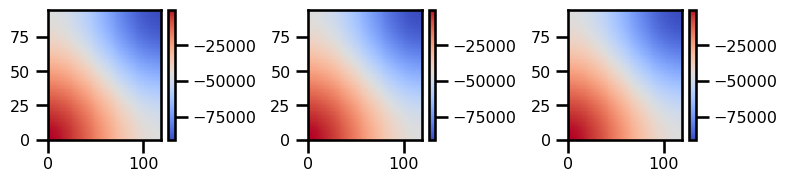

In [69]:
plot_field(H_mat)

### Inversion

We are interested in solving for the Helmholtz equation which is given by

$$
(\boldsymbol{\alpha\nabla}_H^2 - \boldsymbol{\beta})p = q
$$

#### Homogeneous Solution

First, we need to use the scheme to solve the homogeneous Helmholtz equation for the baroclinic nodes.
The homoegeneous equation is given by:

$$
(\boldsymbol{\nabla}_H^2 - \boldsymbol{\beta})p = 0
$$

Let's reformulate the pressure to be:

$$
p = \mathbf{L} + \beta s
$$

where $\mathbf{L}$ is a known solution of the Laplace's equation with non-zero boundaries.

$$
\begin{aligned}
\boldsymbol{\nabla}_H^2\mathbf{L} &= 0 && && x\in\Omega\\
\boldsymbol{F}_{BC}(\mathbf{L}) &= b && && x\in\partial\Omega\\
\end{aligned}
$$

 which is non


In [70]:
class DSTSolution(eqx.Module):
    homsol: Array = eqx.static_field()
    homsol_mean: Array = eqx.static_field()
    H_mat: Array = eqx.static_field()


In [71]:
def compute_homogeneous_solution(
    u: Array, 
    lambda_sq: Array,
    masks: Mask=None
):
    
    # create constant field
    constant_field = jnp.ones_like(u)
    
    # get homogeneous solution
    sol = jax.vmap(inverse_elliptic_dst, in_axes=(0,0))(constant_field[:, 1:-1,1:-1], H_mat)
    
    # calculate the homogeneous solution
    homsol = constant_field + sol * lambda_sq
    
    return homsol

In [72]:
psi0 = jnp.zeros(shape=(layer_domain.Nz,) +xy_domain.Nx)

homsol = compute_homogeneous_solution(
    psi0, 
    lambda_sq=einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")
)

check_field_shapes(homsol, name="psi")

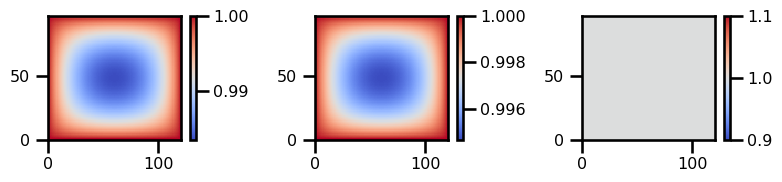

In [73]:
plot_field(homsol)

In [74]:
from jaxsw._src.operators.functional.finitevol.interp import x_average_2D, y_average_2D, center_average_2D

In [81]:
homsol_i = center_average_2D(homsol) * masks.q.u
homsol_mean = einops.reduce(homsol_i, "Nz Nx Ny -> Nz 1 1", reduction="mean")


In [82]:
dst_sol = DSTSolution(homsol=homsol, homsol_mean=homsol_mean, H_mat=H_mat)

## Forcing

## RHS

$$
\begin{aligned}
\text{Advection}: && 
\boldsymbol{D_1} &= 
-\frac{1}{f_0}\boldsymbol{J}(q,p)\\
\text{Diffusion}: && 
\boldsymbol{D_2} &= 
\frac{a_2}{f_0}\boldsymbol{\nabla}_H^4\psi\\
\text{HyperDiffusion}: && 
\boldsymbol{D_2} &= 
-\frac{a_4}{f_0}\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

#### Advection Term

$$
\boldsymbol{D_1} = 
-\frac{1}{f_0}\boldsymbol{J}(q,p)
$$

Here, we will use the (determinant) Jacobian to calculate this.

### Potential Vorticity

$$
q = \nabla^2\psi - f_0^2 A\psi + \beta (y-y_0)
$$

In [85]:
from jaxsw._src.operators.functional.finitevol.difference import laplacian, laplacian_batch
from jaxsw._src.operators.functional.finitevol.geostrophic import gradient_perpendicular, divergence

def calculate_potential_vorticity(
    psi: Array, 
    domain: Domain, 
    layer_domain: LayerDomain, 
    masks_psi=None,
    masks_q=None
) -> Array:
    
    
    # calculate laplacian [Nx,Ny] --> [Nx-2, Ny-2]
    psi_lap = laplacian_batch(psi, domain.dx)
    check_field_shapes(psi_lap, name="psi_i")
    
    # pad 
    # [Nx-2,Ny-2] --> [Nx,Ny]
    psi_lap = jnp.pad(psi_lap, pad_width=((0,0),(1,1),(1,1)), mode="constant", constant_values=0.0)
    
    # apply boundary conditions on psi
    if masks_psi:
        psi_lap *= masks_psi.u

    check_field_shapes(psi_lap, name="psi")
    
    # calculate beta term in helmholtz decomposition
    beta_lap = params.f0**2 * jnp.einsum("lm,...mxy->...lxy", layer_domain.A, psi)
    check_field_shapes(beta_lap, name="psi")
    
    # calculate beta-plane
    f_y = params.beta * (xy_domain.grid_axis[1] - params.y0)
    
    q = psi_lap - beta_lap + f_y
    check_field_shapes(q, name="psi")
    
    
    # [Nx,Ny] --> [Nx-1,Ny-1]
    q = center_average_2D(q)
    check_field_shapes(q, name="q")
    
    # apply boundary conditions on q
    if masks_q:
        q *= masks_q.u
    
    return q

In [86]:
q = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    masks_psi=masks.psi, masks_q=masks.q
)

## Fluxes

$$
\nabla \cdot (\vec{u}q) = \partial_x (uq) + \partial_y (vq)
$$

**Tracer Flux**

$$
\begin{aligned}
(uq) && | && (vq)
\end{aligned}
$$

**Differentiation**

$$
\begin{aligned}
\partial_x (uq) && | && \partial_y (vq)
\end{aligned}
$$

**Divergence**

$$
\begin{aligned}
\partial_x (uq) + \partial_y (vq)
\end{aligned}
$$

In [87]:
# tracer_flux??

In [120]:
from jaxsw._src.operators.functional.interp import flux as F_flux

In [ ]:
def get_flux(q, u, method: str="linear", *kwargs):
    
    return None

In [125]:
def advection_rhs(
    q: Float[Array, "Nx-1 Ny-1"], 
    psi: Float[Array, "Nx Ny"], 
    dx: float, dy: float,
    num_pts: int=1,
    masks_u: Mask=None,
    masks_v: Mask=None
):
    """Calculates the advection term on the RHS of the Multilayer QG
    PDE. It assumes we use an arakawa C-grid whereby the potential 
    vorticity term is on the cell centers, the zonal velocity is on the
    east-west cell faces, and the meridional velocity is on the 
    north-south cell faces.
    
    Velocity:
        u, v = -∂yΨ, ∂xΨ
    Advection:
        u̅⋅∇ q = ∂x(uq) + ∂y(vq)
        
        
    This uses the conservative method which calculates the flux terms
    independently, (uq, vq) and then we calculate the partial 
    derivatives.
    
    Args:
        q (Array): the potential vorticity term on the cell centers
            Size = [Nx-1, Ny-1]
        psi (Array): the stream function on the cell vertices
            Size = [Nx, Ny]
    Returns:
        div_flux (Array): the flux divergence on the cell centers
            Size = [Nx-1, Ny-1]
    
    """
    
    # calculate velocities
    # [Nx,Ny] --> [Nx,Ny-1],[Nx-1,Ny]
    # u, v = ∂yΨ, ∂xΨ
    u, v = gradient_perpendicular(psi, dx, dy)
    # u = -∂yΨ
    u *= -1
    
    # check_field_shapes(u, name="u")
    # check_field_shapes(v, name="v")

    # take interior points of velocities
    # [Nx,Ny-1] --> [Nx-2,Ny-1]
    u_i = u[..., 1:-1, :]
    # [Nx-1,Ny] --> [Nx-1,Ny-2]
    v_i = v[..., 1:-1]
    
    # check_field_shapes(u_i, name="u_i")
    # check_field_shapes(v_i, name="v_i")
    
    # calculate flux terms
    # uq, vq
    # [Nx-1,Ny-1],[Nx-2,Ny-1] --> [Nx-2,Ny-1]
    
    
    q
    q_flux_on_v = tracer_flux_1pt(q=q, u=v_i, dim=1)
    
    
    
    if masks_u is not None:
        # OPTION I - 1pt Flux (Standard Upwind Scheme)
        q_flux_on_u = F_flux.tracer_flux_1pt_mask(
            q=q, u=u_i, dim=0,
            u_mask1=masks_u.distbound1[...,1:-1,:],
        )
        q_flux_on_v = F_flux.tracer_flux_1pt_mask(
            q=q, u=v_i, dim=1,
            u_mask1=masks_v.distbound1[...,1:-1],
            
        )
        
        # OPTION II - 3pt Flux 
        # method - "linear" | "weno" | "wenoz"
        q_flux_on_u = F_flux.tracer_flux_3pt_mask(
            q=q, u=u_i, dim=0, method="linear",
            u_mask1=masks_u.distbound1[...,1:-1,:],
            u_mask2plus=masks_u.distbound2plus[...,1:-1,:], 
        )
        q_flux_on_v = tracer_flux_3pt_mask(
            q=q, u=v_i, dim=1, method="linear",
            u_mask1=masks_v.distbound1[...,1:-1],
            u_mask2plus=masks_v.distbound2plus[...,1:-1], 
            
        )
        
        # OPTION III - 5pt Flux 
        # method - "linear" | "weno" | "wenoz"
        q_flux_on_u = F_flux.tracer_flux_5pt_mask(
            q=q, u=u_i, dim=0, method="linear",
            u_mask1=masks_u.distbound1[...,1:-1,:],
            u_mask2=masks_u.distbound2[...,1:-1,:], 
            u_mask3plus=masks_u.distbound3plus[...,1:-1,:],    
        )
        q_flux_on_v = F_flux.tracer_flux_5pt_mask(
            q=q, u=v_i, dim=1, method="linear",
            u_mask1=masks_v.distbound1[...,1:-1],
            u_mask2=masks_v.distbound2[...,1:-1], 
            u_mask3plus=masks_v.distbound3plus[...,1:-1],   
            
        )
        
    else:
        # OPTION I - 1pt Flux (Standard Upwind Scheme)
        q_flux_on_u = F_flux.tracer_flux_1pt(q=q, u=u_i, dim=0)
        q_flux_on_v = F_flux.tracer_flux_1pt(q=q, u=v_i, dim=1)
        # OPTION II - 3pt Flux 
        # method - "linear" | "weno" | "wenoz"
        q_flux_on_u = F_flux.tracer_flux_3pt(q=q, u=u_i, dim=0, method="wenoz")
        q_flux_on_v = F_flux.tracer_flux_3pt(q=q, u=v_i, dim=1, method="wenoz")
        # OPTION III - 5pt Flux 
        # method - "linear" | "weno" | "wenoz"
        q_flux_on_u = F_flux.tracer_flux_5pt(q=q, u=u_i, dim=0, method="wenoz")
        q_flux_on_v = F_flux.tracer_flux_5pt(q=q, u=v_i, dim=1, method="wenoz")
        
        
        
    
    # check_field_shapes(q_flux_on_u, name="u_i")
    # check_field_shapes(q_flux_on_v, name="v_i")
    
    # pad arrays to comply with velocities (cell faces)
    # [Nx-2,Ny-1] --> [Nx,Ny-1]
    q_flux_on_u = jnp.pad(q_flux_on_u, pad_width=((1,1),(0,0)))
    # [Nx-1,Ny-2] --> [Nx-1,Ny]
    q_flux_on_v = jnp.pad(q_flux_on_v, pad_width=((0,0),(1,1)))
    
    # check_field_shapes(q_flux_on_u, name="u")
    # check_field_shapes(q_flux_on_v, name="v")
    
    # calculate divergence
    # [Nx,Ny-1] --> [Nx-1,Ny-1]
    div_flux = divergence(q_flux_on_u, q_flux_on_v, dx, dy)
    
    # check_field_shapes(div_flux, name="q")
    
    return div_flux

In [129]:
fn = jax.vmap(advection_rhs, in_axes=(0,0,None,None,None,None,None))

div_flux = fn(
    q, psi0, xy_domain.dx[-2],xy_domain.dx[-1], 1, masks.u, masks.v
    # q, psi0, xy_domain.dx[-2],xy_domain.dx[-1], 1, None, None,
)
# div_flux = advection_rhs(
#     q=q, psi=psi0, 
#     dx=xy_domain.dx[-2],
#     dy=xy_domain.dx[-1],
#     masks=masks
# )
check_field_shapes(div_flux, name="q")

### Forcings

#### Bottom Drag

$$
\begin{aligned}
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}f_0^2}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

In [96]:
def calculate_bottom_drag(
    psi: Array, 
    domain: Domain,
    H_z: float,
    delta_ek: float=2.0,
    f0: float=9.375e-05,
    masks_psi=None
) -> Array:
    """
    Equation:
        F_drag: (δₑf₀² / 2Hz)∇²ψN
    """
    
    # interior, vertex points on psi
    # [...,Nx,Ny] --> [...,Nx-2,Ny-2]
    omega = jax.vmap(laplacian, in_axes=(0,None))(psi, domain.dx)
    check_field_shapes(omega, name="psi_i")
    
    # pad interior psi points
    # [Nx,Ny] --> [Nx,Ny]
    omega = jnp.pad(omega, pad_width=((0,0),(1,1),(1,1)), mode="constant", constant_values=0.0)
    
    if masks_psi is not None:
        omega *= masks_psi.u
    
    # pad interior, center points on q
    # [Nx,Ny] --> [Nx-1,Ny-1]
    omega = center_average_2D(omega)
    check_field_shapes(omega, name="q")
    
    # calculate bottom drag coefficient
    bottom_drag_coeff = (delta_ek / H_z) * (f0 / 2.0)
    
    # calculate bottom drag
    bottom_drag = - bottom_drag_coeff * omega[-1]
    check_field_shapes(bottom_drag, name="q")
    
    return bottom_drag

In [98]:
bottom_drag = calculate_bottom_drag(
    psi=psi0, 
    domain=xy_domain, 
    H_z=layer_domain.heights[-1],
    f0=params.f0, 
    masks_psi=masks.psi
)

#### Forcing


$$
\begin{aligned}
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]
\end{aligned}
$$

In [99]:
# y_coords = xy_domain.grid_axis[1]
# tau0 = 0.08 / 1_000
# curl_tau = - tau0 * 2. * jnp.pi/xy_domain.Lx[1] * jnp.sin(2.0 * jnp.pi * y_coords/xy_domain.Lx[1])

# curl_tau = center_average_2D(curl_tau)
# wind_forcing = curl_tau / layer_domain.heights[0]
# check_field_shapes(wind_forcing, name="q")

In [100]:
def calculate_wind_forcing(
    domain: Domain, 
    H_0: float,
    tau0: float=0.08/1_000.0,
) -> Array:
    """
    Equation:
        F_wind: (τ₀ /H₀)(∂xτ−∂yτ)
    """
    
    Ly = domain.Lx[-1]
    
    # [Nx,Ny]
    y_coords = xy_domain.grid_axis[-1]
    
    # center coordinates, cell centers
    # [Nx,Ny] --> [Nx-1,Ny-1]
    y_coords_center = center_average_2D(y_coords)
    
    # calculate tau
    # analytical form! =]
    curl_tau = - tau0 * 2. * jnp.pi/Ly * jnp.sin(2.0 * jnp.pi * y_coords_center/Ly)
    
    wind_forcing = curl_tau / H_0
    check_field_shapes(wind_forcing, name="q")
    return wind_forcing

In [101]:
wind_forcing = calculate_wind_forcing(
    domain=xy_domain,
    H_0=layer_domain.heights[0],
    tau0=0.08/1_000.0,
)

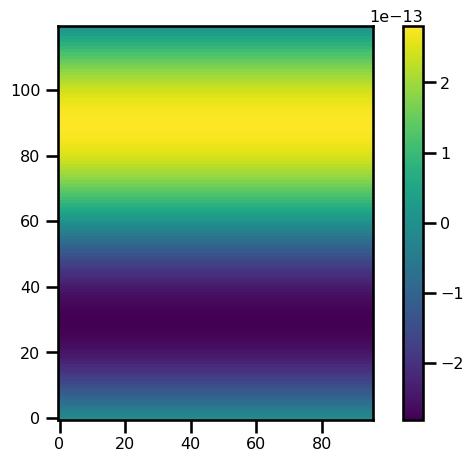

In [102]:
fig, ax = plt.subplots()

pts = ax.imshow(wind_forcing.T, origin="lower")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

#### Total Forces

In [103]:
def add_forces(q):
    
    forces = jnp.zeros_like(q)
    forces = forces.at[0].set(forces[0] + wind_forcing)
    forces = forces.at[-1].set(forces[-1] + bottom_drag)
    return forces
    

In [104]:
forces = jnp.zeros_like(q)

In [105]:
forces = forces.at[0].set(forces[0] + wind_forcing)
forces = forces.at[-1].set(forces[-1] + bottom_drag)

check_field_shapes(forces, name="q")

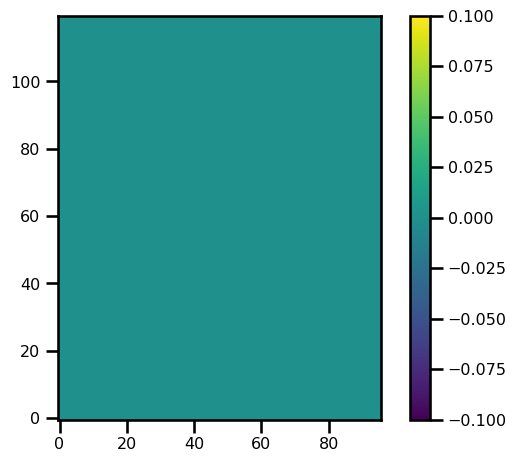

In [106]:
fig, ax = plt.subplots()

pts = ax.imshow(forces[-1].T, origin="lower")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

### Equation of Motion (RHS)

In [107]:
# NOTE!!!! multiply by masks of Q!!!
adv_rhs = - div_flux + forces # * masks.q

check_field_shapes(adv_rhs, name="q")

## Time Derivatives

In [108]:
# advection RHS --> q
# q interior
# CL2m stuffs
# solve helmholtz elliptical stuffs
# mass convservation Stuff

In [113]:
def qg_rhs(
    q: Array, 
    psi: Array, 
    domain: Domain,
    layer_domain: LayerDomain,
    dst_sol: DSTSolution,
    masks=None,
) -> Array:
    
    # use psi for the boundary conditions
    # TODO
    
    # calculate potential vorticity
    q  = calculate_potential_vorticity(
        psi, domain, layer_domain, 
        masks_psi=masks.psi,
        masks_q=masks.q,
    )
    
    # calculate advection
    fn = jax.vmap(advection_rhs, in_axes=(0,0,None,None,None,None,None))

    dq = fn(
        q, psi, xy_domain.dx[-2],xy_domain.dx[-1], 1, masks.u, masks.v)
    # add forces duh
    dq += add_forces(q)
    
    # get interior points (cell verticies interior)
    # [Nx-1,Ny-1] --> [Nx-2,Ny-2]
    dq_i = center_average_2D(dq)
    check_field_shapes(dq_i, name="psi_i")
    
    # calculate helmholtz rhs
    # [Nx-2,Ny-2]
    helmholtz_rhs = jnp.einsum("lm,...mxy->...lxy", layer_domain.A_layer_2_mode, dq_i)
    check_field_shapes(helmholtz_rhs, name="psi_i")
    
    # solve elliptical inversion problem
    # [Nx-2,Ny-2] --> [Nx,Ny]
    dpsi_modes = jax.vmap(inverse_elliptic_dst, in_axes=(0,0))(helmholtz_rhs, dst_sol.H_mat)
    check_field_shapes(dpsi_modes, name="psi")
    
    # Add homogeneous solutions to ensure mass conservation
    # [Nx,Ny] --> [Nx-1,Ny-1]
    dpsi_modes_i = center_average_2D(dpsi_modes)
    check_field_shapes(dpsi_modes_i, name="q")
    
    # [Nz] / [Nx,Ny] --> [Nx,Ny] 
    alpha = - einops.reduce(dpsi_modes_i, "... Nx Ny -> ... 1 1", reduction="mean") / dst_sol.homsol_mean
    
    # [Nx,Ny]
    dpsi_modes += alpha * homsol
    check_field_shapes(dpsi_modes, name="psi")
    
    # [Nx,Ny]
    dpsi = jnp.einsum("LM,...MXY->LXY",layer_domain.A_mode_2_layer, dpsi_modes)
    check_field_shapes(dpsi, name="psi")
    
    
    return dq, dpsi

In [118]:
dq, dpsi = qg_rhs(q, psi0, xy_domain, layer_domain, dst_sol, masks)
dq.shape, dpsi.shape

((3, 96, 120), (3, 97, 121))

**Inverse Solve Elliptical**